# Anatomical receptive field analysis

#### Analysis and visualization pipeline:

1. Loading pre- and postsynaptic cell type curated data sets
        1.1 Selecting data
2. Matching all presynaptic cell ids connecting to each postsynaptic cell
        2.1 Visualization of synaptic weitghs
3. Analysis of spatial span of presynaptic inputs to single postsynaptic cells
        3.1 Quantification of spatial span
4. Plotting distributions of spatial span quantifications
        4.1 Threshold choice for filtering method based on zscores
        4.2 Spatial span distributions and correlations
        4.3 Visually exploring the points used for spatial span quantification
5. Spatial span visualization on top of the medulla

In [80]:
#Importing packages

import os
import pandas as pd
import numpy as np
from scipy import stats
from scipy.spatial import ConvexHull
from sklearn.cluster import DBSCAN
import seaborn as sns
from fafbseg import flywire
from caveclient import CAVEclient
client = CAVEclient('flywire_fafb_production')
from openpyxl import load_workbook
from synapse_queries_helper import combine_xyz
import navis
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

### 0. User parameters

In [81]:
#For analysis purposes
min_desired_count = 3 # minimun desired number of contacts between pre and post neurons to be considered
single_column_area = 100 # un um^2

save_figures = False

# For plotting purposes

hemisphere = 'R' # 'R', 'L'
neuropile_mesh = 'ME_L'
mesh_azim = 16# -18 for ME_R, 16 for ME_L
mesh_elev = -50 # -148 for ME_R, -50 for ME_L

### 1. Loading curated data sets

In [82]:
#Loading information  from excel files
PC_disc = 'D'
dataPath = f'{PC_disc}:\Connectomics-Data\FlyWire\Excels\drive-data-sets\database'
date = '20230912'
pre_neuron_type = 'Dm12'
post_neuron_type = 'Tm9'
fileName_post = f'{post_neuron_type} proofreadings.xlsx'
filePath_post = os.path.join(dataPath,fileName_post)
fileName_pre = f'{pre_neuron_type} proofreadings.xlsx'
filePath_pre = os.path.join(dataPath,fileName_pre)

#Loading file as DataFrame
post_df = pd.read_excel(filePath_post)
pre_df = pd.read_excel(filePath_pre)


#### 1.1 Selecting data

In [94]:
# Filtering data

# Selecting the R optic lobe IDs
R_pre_df = pre_df[pre_df['hemisphere'] == hemisphere].copy()
R_post_df = post_df[post_df['hemisphere'] == hemisphere].copy()

# Selecting the backbone proofread IDs
R_post_df = R_post_df[R_post_df['backbone proofread (Y/N)'] == 'Y'].copy()
#R_post_df = R_post_df[R_post_df['patch_id'] == 'D']

# Selecting presynaptic cells ids
pre_ids = R_pre_df['Updated_seg_id'].tolist()


In [95]:
# Visualize the final data sets
display(R_post_df.head()) # tail or head is fine
display(R_pre_df.tail()) # tail or head is fine

XYZ-ME symbol                   XYZ-LO  \
692  182116.0,75129.0,2484.0    Tm9  170235.0,70370.0,5282.0   
693  181221.0,71952.0,2523.0    Tm9  170742.0,68132.0,5372.0   
694  190086.0,85837.0,3281.0    Tm9  173170.0,78482.0,4592.0   
695  195500.0,50706.0,3987.0    Tm9  181888.0,53114.0,5025.0   
696  195267.0,48669.0,3884.0    Tm9  181672.0,51656.0,5034.0   

      quality comment Mi4-connected rim_area (Y/N) hemisphere             lab  \
692  strange dendrite           NaN              N          R  Axel Borst Lab   
693               NaN           NaN              N          R  Axel Borst Lab   
694               NaN           NaN              N          R   Marion Silies   
695               NaN           NaN              N          R   Marion Silies   
696               NaN           NaN              N          R   Marion Silies   

                      author  \
692             Amalia Braun   
693             Amalia Braun   
694  Sebastian Molina-Obando   
695  Sebastian Molina-Obando   
696  Sebastian Molina-Obando   

                                                  name  ... optic_lobe_id  \
692  Tm9, Tm9_L, transmedullary neuron Tm9, Choline...  ...            R1   
693  Tm9, Tm9_L, transmedullary neuron Tm9, Choline...  ...            R2   
694  Tm9, Tm9_L, transmedullary neuron Tm9, FBbt_00...  ...            R3   
695  Tm9, Tm9_L, transmedullary neuron Tm9, FBbt_00...  ...            R4   
696  Tm9, Tm9_L, transmedullary neuron Tm9, FBbt_00...  ...            R5   

    patch_id column_id  backbone proofread (Y/N) twigs proofread (Y/N)  \
692      NaN       NaN                         Y                     N   
693      NaN       NaN                         Y                     N   
694      NaN       NaN                         Y                     N   
695      NaN       NaN                         Y                     N   
696      NaN       NaN                         Y                     N   

    inputs_proofread (Y/N) dark_neurons (Y/N) healthy_L3 (Y/N)  \
692                      N                NaN                Y   
693                      N                NaN                Y   
694                      Y                NaN                Y   
695                      N                NaN                Y   
696                      Y                NaN                N   

    detached_lamina (Y/N) dorso-ventral  
692                     N             V  
693                     N             V  
694                     N             V  
695                     N             D  
696                     N             D  

[5 rows x 25 columns]

XYZ-ME symbol  XYZ-LO quality comment  total_presynaptic_sites  \
210     NaN   Dm12     NaN             NaN                      NaN   
211     NaN   Dm12     NaN             NaN                      NaN   
212     NaN   Dm12     NaN             NaN                      NaN   
213     NaN   Dm12     NaN             NaN                      NaN   
214     NaN   Dm12     NaN             NaN                      NaN   

    hemisphere  lab  author  name              seg_id  ... optic_lobe_id  \
210          R  NaN     NaN   NaN  720575940646209059  ...     Dm12-R106   
211          R  NaN     NaN   NaN  720575940623783437  ...     Dm12-R107   
212          R  NaN     NaN   NaN  720575940634292119  ...     Dm12-R108   
213          R  NaN     NaN   NaN  720575940633203852  ...     Dm12-R109   
214          R  NaN     NaN   NaN  720575940618595874  ...     Dm12-R110   

    patch_id  column_id backbone proofread (Y/N) twigs proofread (Y/N)  \
210      NaN        NaN                        Y                   NaN   
211      NaN        NaN                        N                   NaN   
212      NaN        NaN                        N                   NaN   
213      NaN        NaN                        Y                   NaN   
214      NaN        NaN                        N                   NaN   

     inputs_proofread (Y/N)  dark_neurons (Y/N) bad_quality_rim (Y/N)  \
210                     NaN                 NaN                   NaN   
211                     NaN                 NaN                   NaN   
212                     NaN                 NaN                   NaN   
213                     NaN                 NaN                   NaN   
214                     NaN                 NaN                   NaN   

    healthy_L3 (Y/N) detached_lamina (Y/N)  
210              NaN                   NaN  
211              NaN                   NaN  
212              NaN                   NaN  
213              NaN                   NaN  
214              NaN                   NaN  

[5 rows x 24 columns]

### 2. Matching all presynaptic cell ids connecting to each postsynaptic cell

In [96]:
# Updating presynaptic neurons if they are not up-to-date
if not np.unique(flywire.is_latest_root(pre_ids))[0]: #if not up-to-date
    update_df = flywire.update_ids(pre_ids, stop_layer=2, supervoxels=None, timestamp=None, dataset='production', progress=True)
    up_to_date_pre_ids = update_df['new_id'].tolist()
    display(update_df[update_df['changed'] == True])
    if len(update_df[update_df['confidence']< 1]) == 0:
        print('Good to go and match ids in the next step')
    else:
        print('Consider updating your ids in the original data set')
else:
    up_to_date_pre_ids = [int(x) for x in pre_ids]
    print('All pre ids were up to date')
    


Updating:   0%|          | 0/110 [00:00<?, ?it/s]

old_id              new_id  confidence  changed
8    720575940633681235  720575940633782436        1.00     True
9    720575940627971709  720575940621626560        1.00     True
20   720575940614311661  720575940639070554        1.00     True
29   720575940612811925  720575940640957016        1.00     True
33   720575940618740507  720575940622146470        1.00     True
39   720575940631099708  720575940633977645        1.00     True
46   720575940629488646  720575940615956118        1.00     True
55   720575940622687220  720575940630032144        1.00     True
67   720575940606569318  720575940628822088        1.00     True
72   720575940624885685  720575940632539407        0.99     True
97   720575940625460459  720575940613750954        1.00     True
102  720575940613394546  720575940616675394        1.00     True

Consider updating your ids in the original data set


In [98]:
## Getting postsynaptic side ID
post_ids = R_post_df['Updated_seg_id'].tolist()

## Getting all synaptic connections

# Quick update
if not np.unique(flywire.is_latest_root(post_ids))[0]: # if not up-to-date
    #Updating the IDs via Fafbseg
    update_df = flywire.update_ids(post_ids, stop_layer=2, supervoxels=None, timestamp=None, dataset='production', progress=True)
    up_to_date_post_ids = update_df['new_id']
    display(update_df[update_df['confidence'] < 1])
else:
    up_to_date_post_ids = [int(x) for x in post_ids]
    print('All post ids were up to date')
    

# Fetch the neuron's inputs
post_inputs = flywire.synapses.fetch_synapses(up_to_date_post_ids, pre=False, post=True, attach=True, 
                                             min_score=50, clean=True, transmitters=False, 
                                             neuropils=True, batch_size=30, 
                                             dataset='production', progress=True,mat= "live")

#Combining pre- and postsynpases XYZ values in single columns
combine_xyz(post_inputs) # Function that does the operation

# Filtering: keeping only synapses in the medulla
post_inputs = post_inputs[post_inputs['neuropil'] == neuropile_mesh].copy()
len(post_inputs)

# Filter connections just selected presynaptic cells
pre_post_match_df = post_inputs[post_inputs['pre_pt_root_id'].isin(up_to_date_pre_ids)].copy()
display(pre_post_match_df.head())

# Aggregating data frame based on unique post and pre segment IDs
# While aggregating, counting the number of contacts for each pre-post pair
pre_post_counts = pre_post_match_df.groupby(['post_pt_root_id', 'pre_pt_root_id'])['pre_pt_root_id'].count().reset_index(name='pre_syn_count')
display(pre_post_counts.head())


Updating:   0%|          | 0/682 [00:00<?, ?it/s]

Empty DataFrame
Columns: [old_id, new_id, confidence, changed]
Index: []

Fetching synapses:   0%|          | 0/23 [00:00<?, ?it/s]

pre_pt_root_id     post_pt_root_id  cleft_score   pre_x   pre_y  \
21   720575940624077005  720575940626579087          155  714384  331676   
70   720575940623345878  720575940659650945          142  778372  365500   
71   720575940623345878  720575940659650945          145  778368  365496   
72   720575940633432659  720575940630963275          143  767804  226416   
295  720575940632751928  720575940627342408          136  781400  352268   

      pre_z  post_x  post_y  post_z         id neuropil  \
21   109080  714288  331716  109080  221908202     ME_L   
70   169480  778256  365536  169480    5228051     ME_L   
71   169520  778212  365528  169560    5228061     ME_L   
72   125000  767796  226500  124960   77624730     ME_L   
295  157200  781416  352136  157160  240226604     ME_L   

                post_pt_position              pre_pt_position  
21   [178572.0, 82929.0, 2727.0]  [178596.0, 82919.0, 2727.0]  
70   [194564.0, 91384.0, 4237.0]  [194593.0, 91375.0, 4237.0]  
71   [194553.0, 91382.0, 4239.0]  [194592.0, 91374.0, 4238.0]  
72   [191949.0, 56625.0, 3124.0]  [191951.0, 56604.0, 3125.0]  
295  [195354.0, 88034.0, 3929.0]  [195350.0, 88067.0, 3930.0]

post_pt_root_id      pre_pt_root_id  pre_syn_count
0  720575940600084489  720575940620506704              3
1  720575940600084489  720575940622432895              3
2  720575940600084489  720575940633977645              8
3  720575940602880736  720575940612534641              3
4  720575940602880736  720575940619165509              3

#### 2.1 Visualization of synaptic weitghs

In [ ]:
# Quick visualization of the weight of our presynaptic partner of interest as input of our postsynaptoc cell of interest

# Synaptic counts filter
pre_post_counts = pre_post_counts[pre_post_counts['pre_syn_count']>=min_desired_count].copy()

#Geeting all input counts for each presynaptic neuron id
post_inputs_counts = post_inputs.groupby(['post_pt_root_id', 'pre_pt_root_id'])['pre_pt_root_id'].count().reset_index(name='pre_syn_count')

#Initializing variables
rel_neuron_type_weight = []
rel_neuron_weight = []
neuron_weight_post_ls = []
neuron_weight_pre_ls = []
#Looping to get the neuron and neuron type weigths to each postsynaptic partner
for _post in list(set(post_inputs_counts['post_pt_root_id'].tolist())):
    curr_df = post_inputs_counts[post_inputs_counts['post_pt_root_id'] == _post].copy()
    curr_total_syn_count = curr_df['pre_syn_count'].sum()
    curr_pre_type_df = curr_df[curr_df['pre_pt_root_id'].isin(up_to_date_pre_ids)].copy()
    # Weitgh for all cell of the same type
    curr_rel_neuron_type_weight = curr_pre_type_df['pre_syn_count'].sum()/curr_total_syn_count
    rel_neuron_type_weight.append(curr_rel_neuron_type_weight)
    # Weitgh for individual cell of the same type
    if len(curr_pre_type_df['pre_pt_root_id']) == 0:
        rel_neuron_weight.append(0.0)
        neuron_weight_post_ls.append(_post) # tracking the postsynaptic neuron ids
        neuron_weight_pre_ls.append('-') # tracking the presynaptic neuron ids
    else:
        for _pre in list(set(curr_pre_type_df['pre_pt_root_id'].tolist())):
            neuron_weight_post_ls.append(_post) # tracking the postsynaptic neuron ids
            neuron_weight_pre_ls.append(_pre) # tracking the presynaptic neuron ids
            curr_rel_neuron_weight = curr_pre_type_df[curr_pre_type_df['pre_pt_root_id'] == _pre]['pre_syn_count'].sum() / curr_total_syn_count
            rel_neuron_weight.append(curr_rel_neuron_weight)

#Summary data frames
neuron_weight_df = pd.DataFrame()
neuron_weight_df['rel_weight'] = rel_neuron_weight
neuron_weight_df['post'] = neuron_weight_post_ls
neuron_weight_df['pre'] = neuron_weight_pre_ls 

In [ ]:
# Plotting 

#Filtering out 0 values
#rel_neuron_type_weight = [x for x in rel_neuron_type_weight if x != 0]
#rel_neuron_weight = [x for x in rel_neuron_weight if x != 0] 

# Calculate the percentage values
rel_neuron_type_weight_percent = [x * 100 for x in rel_neuron_type_weight] 
rel_neuron_weight_percent = [x * 100 for x in rel_neuron_weight] 

# Create subplots for each dimension using Seaborn
plt.figure(figsize=(12, 4))

plt.subplot(131)  # 1 row, 3 columns, 1st subplot
sns.histplot(rel_neuron_type_weight_percent, bins=20, color='blue', alpha=0.7, kde=True)
plt.title(f'Neuron type weight: {pre_neuron_type}({len(pre_ids)})>{post_neuron_type}({len(post_ids)})')
plt.xlabel('Input fraction (%)')  # Update the x-axis label
plt.ylabel(f'{post_neuron_type} counts (total: {len(rel_neuron_type_weight_percent)})')  # Update the x-axis label

plt.subplot(132)  # 1 row, 3 columns, 2nd subplot
sns.histplot(rel_neuron_weight_percent, bins=20, color='green', alpha=0.7, kde=True)
plt.title(f'Neuron weight: {pre_neuron_type}({len(pre_ids)})>{post_neuron_type}({len(post_ids)})')
plt.xlabel('Input fraction (%)')  # Update the x-axis label
plt.ylabel(f'{pre_neuron_type}>{post_neuron_type} counts (total: {len(rel_neuron_weight_percent)})')  # Update the x-axis label

plt.tight_layout()  # Ensure proper spacing between subplots
plt.show()

### 3. Analysis of spatial span of presynaptic inputs to single postsynaptic cells

In [50]:
# Synaptic counts filter
pre_post_counts = pre_post_counts[pre_post_counts['pre_syn_count']>=min_desired_count].copy()
display(pre_post_counts)

post_pt_root_id      pre_pt_root_id  pre_syn_count
0    720575940606989001  720575940613074394              4
1    720575940606989001  720575940617876953             11
4    720575940608490761  720575940606052012              3
9    720575940609986680  720575940631067452              4
18   720575940614631422  720575940617876953              7
19   720575940614631422  720575940621822657              3
22   720575940615464098  720575940624180735              5
23   720575940615464098  720575940636076639              6
28   720575940618614592  720575940606052012              4
30   720575940618701888  720575940621822657              3
31   720575940618701888  720575940636076639              6
32   720575940619538993  720575940613074394              4
33   720575940619538993  720575940624437956              3
37   720575940619913863  720575940625031351              3
38   720575940619947349  720575940606052012              3
40   720575940619947349  720575940632765288              3
41   720575940620176293  720575940606052012              4
44   720575940620567723  720575940621822657              3
45   720575940620567723  720575940636076639              3
48   720575940621168255  720575940624180735              4
49   720575940621168255  720575940625031351              3
53   720575940621573547  720575940632765288              6
56   720575940621714047  720575940625031351              3
59   720575940622187132  720575940636076639              5
61   720575940622265513  720575940624437956              3
62   720575940622265513  720575940632765288              3
64   720575940622355226  720575940625031351              5
69   720575940623738886  720575940613074394              3
72   720575940623931115  720575940613074394              3
77   720575940624753812  720575940606052012              4
78   720575940624753812  720575940624437956              3
79   720575940624753812  720575940628875688              3
80   720575940625533164  720575940613074394              3
84   720575940625859709  720575940613074394              6
85   720575940625859709  720575940617876953              3
93   720575940627788157  720575940632765288              3
100  720575940629466097  720575940632765288              3
101  720575940629466097  720575940636076639              6
102  720575940629984055  720575940613074394              5
108  720575940630507991  720575940613074394              4
109  720575940630507991  720575940617876953              4
110  720575940630724204  720575940624180735              5
117  720575940631746090  720575940628875688              3
118  720575940632098607  720575940606052012              3
121  720575940633161005  720575940625031351              4
123  720575940633205412  720575940624437956              4
124  720575940633767906  720575940624180735              5
126  720575940633767906  720575940636076639              3
127  720575940635236447  720575940613074394              4
131  720575940636145775  720575940613074394              4
136  720575940639230948  720575940632765288              5

In [51]:
## Geeting information for all pre cells 
pre_ls = pre_post_counts['pre_pt_root_id'].tolist() # all postsynaptic neurons

# Fetch the inputs from presynaptic cells
#TODO change "pre_inputs" to "pre_connectivity" (which includes inputs and outputs)
pre_inputs = flywire.synapses.fetch_synapses(pre_ls, pre=True, post=True, attach=True, 
                                             min_score=50, clean=True, transmitters=False, 
                                             neuropils=True, batch_size=30, 
                                             dataset='production', progress=True,mat= "live")

# Filtering: keeping only synapses in the medulla
pre_inputs = pre_inputs[pre_inputs['neuropil'] == neuropile_mesh].copy()
len(pre_inputs)

#Combining pre- and postsynpases XYZ values in single columns
combine_xyz(pre_inputs) # Function that does the operation

Fetching synapses:   0%|          | 0/2 [00:00<?, ?it/s]

#### 3.1 Quantification of spatial span

In [53]:
### Quantification of spatial span

''' 
IMPORTANT NOTE: the current method to filter out points (outliers) is not good enough since it is also discarding good ones
I NEED something better, an approach based on clustering or Nearest neightbour distance. 
Thinking in progress.., but it doesn´t seem to work.
Both previous approaches are currently commented out.

Juan´s clever suggestion: change the apporach how to get the plane for the area of interest. 
The idea is to first define the column axis (based on unicolumnar neuron, like Tm9) and then get the plane for the
presynaptic cloud of points  perpendicular to that axis.
'''

outliers_threshold = 3  # 2 for method meadian
outliers_method = 'median' # 'mean', 'median'


pre_post_volumes = []
pre_post_areas = []
pre_count = []
pre_xzy_ls = []
post_xzy_ls = []
pre_center_ls = []
num_points = []
hull_ls = []
for i in range(0,len(up_to_date_post_ids)):

    curr_post = up_to_date_post_ids[i] 
    #display(pre_post_counts[pre_post_counts['post'] == curr_post])
    
    # Getting single postynaptic cells coordinate
    try:
        old_curr_post = update_df[update_df['new_id'] == curr_post]['old_id'].tolist()[0]
    except:
        old_curr_post = str(curr_post)
        
    single_post_coords = R_post_df[R_post_df['Updated_seg_id'] == old_curr_post]['XYZ-ME'].to_numpy(dtype=str, copy=True)
    post_xyz = np.zeros([np.shape(single_post_coords)[0],3])
    new_post_coords = np.zeros([np.shape(single_post_coords)[0],3])
    for idx, coordinate in enumerate(single_post_coords):
        post_xyz[idx,:] = np.array([coordinate.split(',')],dtype=float)
        new_post_coords[idx,:] = np.array([coordinate.split(',')],dtype=float)
    post_xyz *=[4,4,40] # For plotting it using navis (correcting for data resolution)
    post_xzy_ls.append(post_xyz)
    
    # Getting presynaptic cells coordinates based on postsynaptic location
    curr_post_inputs = pd.DataFrame()
    curr_post_inputs = curr_post_inputs.append(post_inputs[post_inputs['post_pt_root_id']== curr_post].copy()) # here 'post' in the post_inputs dataframe are our candidate postsynaptic cell


    # Getting presynaptic cells coordinates based on postsynaptic location
    curr_pre_ls = pre_post_counts[pre_post_counts['post_pt_root_id'] == curr_post]['pre_pt_root_id'].tolist() # single postsynaptic neuron candidate
    curr_pre_inputs = pd.DataFrame()
    curr_pre_inputs = curr_pre_inputs.append(pre_inputs[pre_inputs['post_pt_root_id'].isin(curr_pre_ls)].copy()) # here 'post' in the pre_inputs dataframe are our candidate presynapic cells
    #curr_pre_inputs = curr_pre_inputs.append(pre_inputs[pre_inputs['pre_pt_root_id'].isin(curr_pre_ls)].copy()) # here 'pre' in the pre_inputs dataframe are our candidate presynapic cells


    if len(curr_pre_inputs) < 10: # if the postsynaptic neuron do not contact any presynaptic one or it has less than 10 synapses
        pre_post_volumes.append(None)
        pre_post_areas.append(None)
        pre_count.append(None)
        pre_xzy_ls.append(None)
        pre_center_ls.append(None)
        num_points.append(None)
        hull_ls.append(None)

    
    else:
        pre_count.append(len(curr_pre_ls))
        # Getting presynaptic cells coordinates
        temp_pre_coords = curr_pre_inputs['pre_pt_position'].tolist()
        
        ## Filtering outliers
        # zscore from scipy (standardizing data and then calculating the score)
        z_scores = np.abs(stats.zscore(temp_pre_coords))
        
        # Manual zscore based on mean
        mean = np.mean(temp_pre_coords, axis=0)
        stddev = np.std(temp_pre_coords, axis=0)
        z_scores_mean = np.abs((temp_pre_coords - mean) / stddev)
        
        # Manual zscore based on median
        median = np.median(temp_pre_coords, axis=0)
        mad = np.median(np.abs(temp_pre_coords - median), axis=0) # Median abosolute deviation

        # Calculate the z-scores using the median and MAD
        z_scores_median = np.abs((temp_pre_coords- median) / mad)
        
# Commented out (filter based on outliers)
#         # Applying outlier filter
#         if outliers_method == 'mean':
#             outlier_indices = np.where(z_scores_mean > outliers_threshold)
#         elif outliers_method == 'median':
#             outlier_indices = np.where(z_scores_median > outliers_threshold)
#         temp_pre_coords = np.delete(temp_pre_coords, outlier_indices, axis=0)
        
# Commented out (filter based on clustering)      
#         # Initialize DBSCAN with appropriate parameters
#         eps = 500  # Adjust the neighborhood radius as needed
#         min_samples = len(temp_pre_coords) / 5  # Adjust the minimum number of points in a cluster as needed
#         dbscan = DBSCAN(eps=eps, min_samples=min_samples)

#         # Applying DBSCAN filter
#         # Fit the DBSCAN model to your data
#         dbscan.fit(temp_pre_coords)

#         # Find the indices of points that belong to clusters (excluding outliers)
#         clustered_indices = np.where(dbscan.labels_ != -1)

#         # Convert clustered_indices to a list of integers
#         clustered_indices = clustered_indices[0]

#         # Filter the points that belong to clusters
#         filtered_points = [temp_pre_coords[i] for i in clustered_indices]
#         temp_pre_coords = filtered_points # rewritting the variable

        
        # Correcting xyz positions for mesh plotting
        pre_xyz = np.array([list(np.array(l)*[4,4,40]) for l in temp_pre_coords])
        pre_xzy_ls.append(pre_xyz)
        num_points.append(len(pre_xyz)) # Total number of points in the presynaptioc partner(s)

        # Calculate the center of the cloud of points
        pre_center = np.mean(pre_xyz, axis=0)
        pre_center_ls.append(pre_center)


        # Calculate the volume of the cloud using the convex hull method
        hull = ConvexHull(pre_xyz)
        volume = hull.volume
        pre_post_volumes.append(volume)
        
        ## Calculate volume/are based on projections using  PCA on PREsynaptic partner coordinates
        #PCA to get an approximate area of the volume
        # Step 1: Center the data
        pre_mean = np.mean(pre_xyz, axis=0)
        pre_centered_points = pre_xyz - pre_mean

        # Step 2: Calculate the covariance matrix
        pre_cov_matrix = np.cov(pre_centered_points, rowvar=False)


        # Step 3: Perform PCA to find the normal vector (eigenvector)
        pre_eigenvalues, pre_eigenvectors = np.linalg.eigh(pre_cov_matrix)
        pre_normal_vector = pre_eigenvectors[:, [1, 2]]  # PC2 and PC3
        
        ## Calculate volume/are based on projections using  PCA on POSTsynaptic partner coordinates
        #PCA to get an approximate area of the volume
        
        # Getting postynaptic cells coordinates
        temp_post_coords = curr_post_inputs['pre_pt_position'].tolist()
        post_xyz = np.array([list(np.array(l)*[4,4,40]) for l in temp_post_coords])
        
        
        # Step 1: Center the data
        post_mean = np.mean(post_xyz, axis=0)
        post_centered_points = post_xyz - post_mean

        # Step 2: Calculate the covariance matrix
        post_cov_matrix = np.cov(post_centered_points, rowvar=False)

        # Step 3: Perform PCA to find the normal vector (eigenvector)
        post_eigenvalues, post_eigenvectors = np.linalg.eigh(post_cov_matrix)
        post_normal_vector = post_eigenvectors[:, [0, 1]]  # PC1 and PC2
        
        
        # Step 4: Project the points
        #projected_points = pre_centered_points.dot(pre_normal_vector)
        projected_points = pre_centered_points.dot(post_normal_vector)

        #Calculate area
        # Calculate the convex hull of the projected points
        hull = ConvexHull(projected_points)
        hull_ls.append(hull)

        # Calculate the area of the convex hull
        area = hull.volume  # Area is calculated as volume in 2D
        area_um2 = area / 10**6
        pre_post_areas.append(area_um2)

        # Calculate the vector from the single point to the center of the cloud
        vector_to_center = pre_center - post_xyz
        #vector_to_center *= 10


# Summary data frame
spatial_span_df = pd.DataFrame()
spatial_span_df['bodyId_post'] = up_to_date_post_ids
spatial_span_df['Volume'] = pre_post_volumes
spatial_span_df['Area'] = pre_post_areas
spatial_span_df['Hull'] = hull_ls
spatial_span_df['Pre_count'] = pre_count
spatial_span_df['Pre_xyz'] = pre_xzy_ls
spatial_span_df['Pre_center'] = pre_center_ls
spatial_span_df['Post_xyz'] = post_xzy_ls
spatial_span_df.set_index('bodyId_post', inplace =True)
spatial_span_df['Area_zscore'] = (spatial_span_df['Area'] - spatial_span_df['Area'].mean()) / spatial_span_df['Area'].std()
spatial_span_df['Num_points'] = num_points
spatial_span_df['Num_columns'] = [round(area / single_column_area) if area is not None else None for area in pre_post_areas]

### 4. Plotting distributions of spatial span quantifications

#### 4.1 Threshold choice for filtering method based on zscores

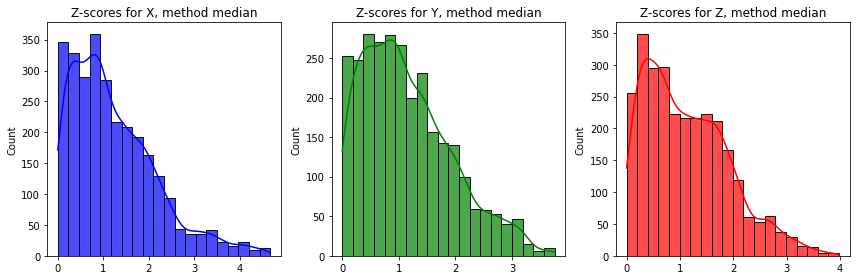

In [54]:
# #Briefly checking zscore to tune the threshold used above
# Generate example z-scores for X, Y, and Z dimensions
if outliers_method == 'mean':
    z_scores_x = z_scores_mean[:,0]
    z_scores_y = z_scores_mean[:,1]
    z_scores_z = z_scores_mean[:,2]
elif outliers_method == 'median':

    z_scores_x = z_scores_median[:,0]
    z_scores_y = z_scores_median[:,1]
    z_scores_z = z_scores_median[:,2]

# Create subplots for each dimension using Seaborn
plt.figure(figsize=(12, 4))

plt.subplot(131)  # 1 row, 3 columns, 1st subplot
sns.histplot(z_scores_x, bins=20, color='blue', alpha=0.7, kde=True)
plt.title(f'Z-scores for X, method {outliers_method}')

plt.subplot(132)  # 1 row, 3 columns, 2nd subplot
sns.histplot(z_scores_y, bins=20, color='green', alpha=0.7, kde=True)
plt.title(f'Z-scores for Y, method {outliers_method}')

plt.subplot(133)  # 1 row, 3 columns, 3rd subplot
sns.histplot(z_scores_z, bins=20, color='red', alpha=0.7, kde=True)
plt.title(f'Z-scores for Z, method {outliers_method}')

plt.tight_layout()  # Ensure proper spacing between subplots
plt.show()

#### 4.2 Spatial span distributions and correlations

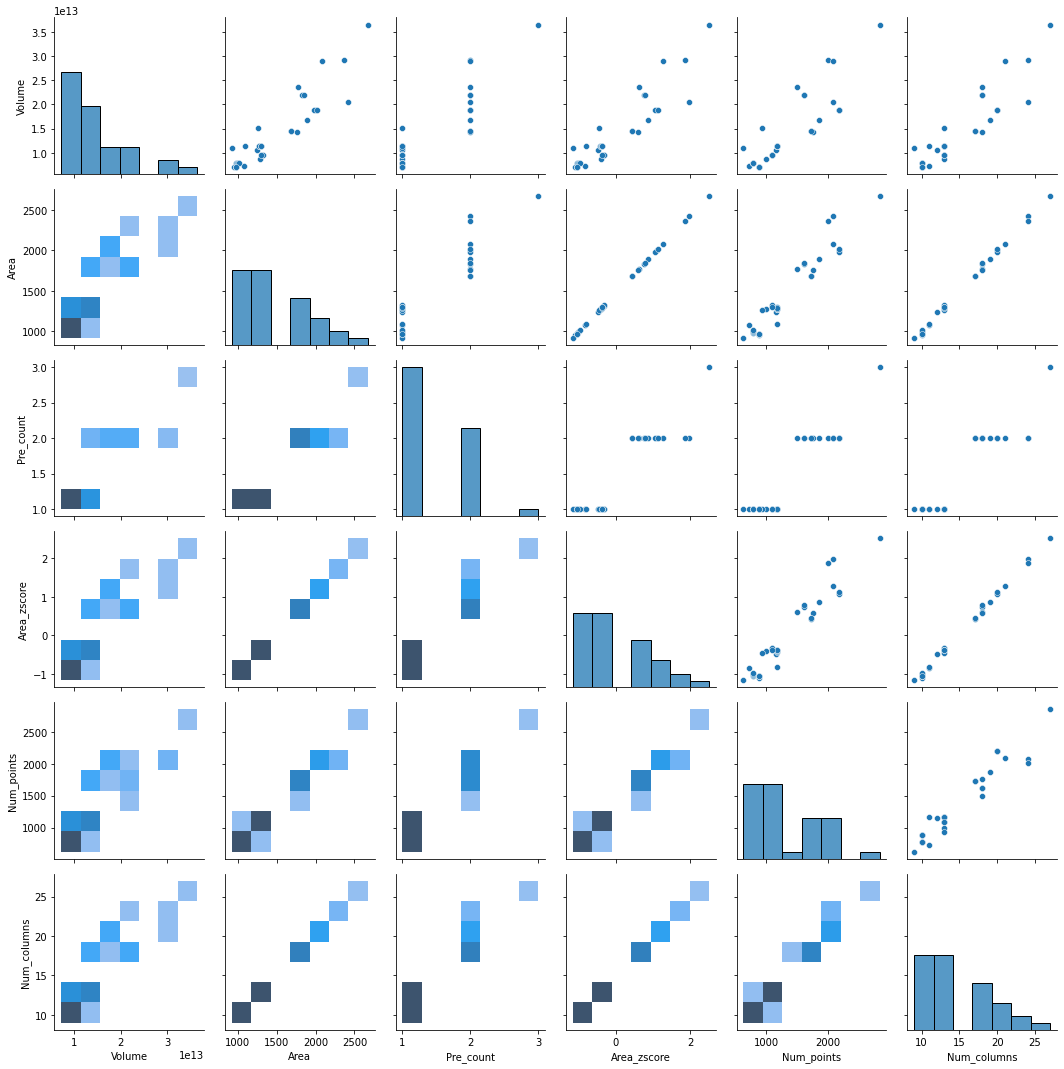

In [55]:
## Brief data visualization with seaborn

# Data
_data = spatial_span_df[spatial_span_df['Pre_count'] == 1].copy()
_data = spatial_span_df.copy()

# Plot
g = sns.PairGrid(_data)
g.map_diag(sns.histplot)
g.map_upper(sns.scatterplot)
g.map_lower(sns.histplot)

# g.axes[0, 0].set_ylabel("Volume (nm^3)")
# g.axes[1, 0].set_ylabel("Area (um^2)")
# g.axes[2, 0].set_ylabel("Partner count")
# g.axes[2, 0].set_xlabel("Volume (nm^3)")
# g.axes[2, 1].set_xlabel("Area (um^2)")
# g.axes[2, 2].set_xlabel("Partner count")


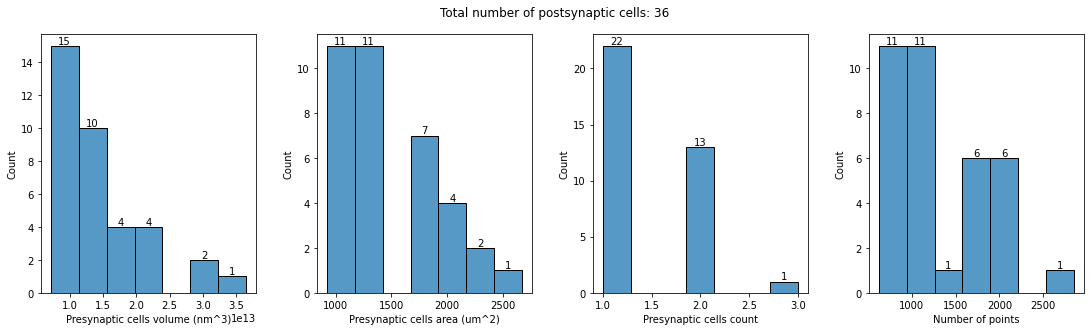

In [56]:
## Brief data distribution visualization adding numbers

# Data
_data = spatial_span_df.copy()
#_data = _data[_data['Pre_count'] == 1.0] # Filtering in columns wiht single presynaptic partner

# Plot
cm = 1/2.54  # centimeters in inches
fig, axs = plt.subplots(nrows=1, ncols=4, figsize = (40*cm, 12*cm))
fig.tight_layout(pad=3)
fig.suptitle(f"Total number of postsynaptic cells: {len(_data [~np.isnan(_data['Area'])])}")

# Plot histograms and annotate bars in each subplot
histograms = [_data['Volume'], _data['Area'], _data['Pre_count'],_data['Num_points']]
subplot_labels = ['Presynaptic cells volume (nm^3)', 'Presynaptic cells area (um^2)', 'Presynaptic cells count', 'Number of points']


for i, data in enumerate(histograms):
    sns.histplot(data, ax=axs[i])
    axs[i].set_ylabel('Count')
    axs[i].set_xlabel(subplot_labels[i])
    
    # Annotate the bars with counts for bars with height > 0
    for p in axs[i].patches:
        if p.get_height() > 0:
            axs[i].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')

# for i, data in enumerate(histograms):
#     sns.histplot(data, ax=axs[i // 2, i % 2])
#     axs[i // 2, i % 2].set_ylabel('Count')
#     axs[i // 2, i % 2].set_xlabel(subplot_labels[i])
    
#     # Annotate the bars with counts for bars with height > 0
#     for p in axs[i // 2, i % 2].patches:
#         if p.get_height() > 0:
#             axs[i // 2, i % 2].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')

# Show the plot
plt.show()

#### 4.3 Visually exploring the points used for spatial span quantification

In [57]:
import plotly.graph_objects as go

_data = _data [~np.isnan(_data['Area'])].copy()

# Create an empty figure
fig = go.Figure()

# Define the marker size (adjust this value as needed)
marker_size = 2  # Change this value to your desired marker size


for post_id in  _data.index.tolist():
    curr_pre_coords = _data.loc[[post_id]]['Pre_xyz'].tolist()[0]
    
    #print(post_id)
    trace = go.Scatter3d(
        x=curr_pre_coords[:, 0],
        y=curr_pre_coords[:, 1],
        z=curr_pre_coords[:, 2],
        mode='lines+markers',  # Combine lines and markers
        marker=dict(size=marker_size),
        line=dict(width=2)  
    )
    fig.add_trace(trace)

# Show the figure
fig.show()

### 5. Spatial span visualization on top of the medulla

#### 5.1 Visualization of presynaptic partners locations

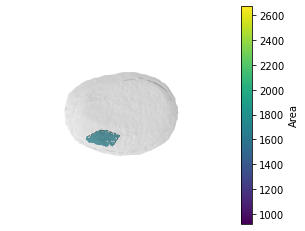

In [66]:
## Visualization of RF size on top of the medulla (color coded)
#%matplotlib notebook
%matplotlib inline
# Data

_variable = 'Area' # 'Area' 'Area_zscore'
_pre_count = 2
_max_num_RF_plotted = 1
_skip = 1 # Skip to next RF

_data = spatial_span_df[~np.isnan(spatial_span_df[_variable])] # Filtering out rows with no area
#_data = _data[_data['Pre_count'] == 2 ] # Filtering in columns wiht "x" nume of presynaptic partners
#_data = _data[(_data[_variable] > (_data[_variable].mean() - 1)) & (_data[_variable] < (_data[_variable].mean() + 1))] # Filtering out rows based on area values

# Define a colormap based on the values in _data['Area']
cmap = plt.get_cmap('viridis')  # You can choose any other colormap

# Normalize the Area values to map them to the colormap
normalize = plt.Normalize(vmin=_data[_variable].min(), vmax=_data[_variable].max())

# Plot
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

loop_count = 0
for _area, post_id in zip(_data[_variable].tolist(), _data[_variable].index.tolist()):
    
    curr_post_coords = _data.at[post_id, 'Post_xyz']
    
    curr_pre_coords = _data.loc[[post_id]]['Pre_xyz'].tolist()[0]
    
    # Map the Area value to a color from the colormap
    _color = cmap(normalize(_area))
    
    #Presynaptic neuron coords
    if _data.loc[[post_id]]['Pre_count'].tolist()[0] == _pre_count:
        if _skip != 0:
            _skip -= 1
            continue
        ax.scatter(curr_pre_coords[:, 0], curr_pre_coords[:, 1], curr_pre_coords[:, 2], '.', 
                   color=_color, s=0.1, alpha= 1, zorder=1)
        #Hull (plotting perimeter based on vertices)
        hull = _data.at[post_id, 'Hull']
        ax.plot(curr_pre_coords[hull.vertices,0], curr_pre_coords[hull.vertices,1], 
                curr_pre_coords[hull.vertices,2], 'k--', lw=0.75, zorder=3)
        
        #Potsynaptic neuron coords
        ax.scatter(curr_post_coords[:, 0], curr_post_coords[:, 1], curr_post_coords[:, 2], '.', color='k', s=5, zorder=2)
        
        loop_count += 1
    if loop_count == _max_num_RF_plotted:
        break
    
    

# Create a colorbar for reference
sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
sm.set_array([])  # An empty array is sufficient
cbar = plt.colorbar(sm, label= f'{_variable}')
 

OL_R = flywire.get_neuropil_volumes([neuropile_mesh]) 
navis.plot2d([OL_R], method='3d_complex', ax=ax) # scalebar = '20 um'

ax.azim = mesh_azim
ax.elev = mesh_elev

plt.show()
# Quick saving:
if save_figures:
    save_path = f'{PC_disc}:\Connectomics-Data\FlyWire\Pdf-plots' #r'D:\Connectomics-Data\FlyWire\Pdf-plots' 
    figure_title = f'\Meshes_XYZ_positions_{post_neuron_type}_RF_size_in_area_based_on_{_pre_count}_{pre_neuron_type}_{hemisphere}_2.pdf'
    fig.savefig(save_path+figure_title)
    print('FIGURE: Anatomica RF size plotted and saved')
plt.close(fig)


In [280]:
if save_figures:    
    save_path = f'{PC_disc}:\Connectomics-Data\FlyWire\Pdf-plots' #r'D:\Connectomics-Data\FlyWire\Pdf-plots' 
    figure_title = f'\Meshes_XYZ_positions_{post_neuron_type}_RF_size_in_area_based_on_{_pre_count}_{pre_neuron_type}_{hemisphere}_2.pdf'
    fig.savefig(save_path+figure_title)
    print('FIGURE: Anatomica RF size plotted and saved')

FIGURE: Anatomica RF size plotted and saved


#### 5.1 Visualization of postsynaptic partners locations


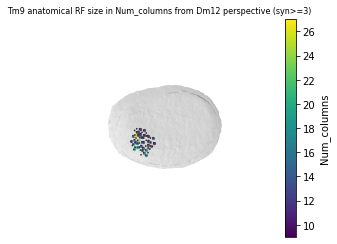

In [67]:
## Visualization of RF size on top of the medulla (color coded)
#%matplotlib notebook
%matplotlib inline
# Data

_variable = 'Num_columns' # 'Area' 'Area_zscore'
_data = spatial_span_df[~np.isnan(spatial_span_df[_variable])] # Filtering out rows with no area
#_data = _data[_data['Pre_count'] == 1.0] # Filtering in columns wiht single presynaptic partner
#_data = _data[(_data[_variable] > (_data[_variable].mean() - 1)) & (_data[_variable] < (_data[_variable].mean() + 1))] # Filtering out rows based on area values

# Define a colormap based on the values in _data['Area']
cmap = plt.get_cmap('viridis')  # You can choose any other colormap

# Normalize the Area values to map them to the colormap
normalize = plt.Normalize(vmin=_data[_variable].min(), vmax=_data[_variable].max())

# Plot
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for _area, post_id in zip(_data[_variable].tolist(), _data[_variable].index.tolist()):
    curr_post_coords = _data.at[post_id, 'Post_xyz']
    
    # Map the Area value to a color from the colormap
    _color = cmap(normalize(_area))
    
    ax.scatter(curr_post_coords[:, 0], curr_post_coords[:, 1], curr_post_coords[:, 2], '.', color=_color, s=5)

# Create a colorbar for reference
sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
sm.set_array([])  # An empty array is sufficient
cbar = plt.colorbar(sm, label= f'{_variable}')
 

OL_R = flywire.get_neuropil_volumes([neuropile_mesh]) 
navis.plot2d([OL_R], method='3d_complex', ax=ax) # scalebar = '20 um'

#Plloting all post_id locations
xyz_post_array = np.concatenate(spatial_span_df['Post_xyz'].values, axis=0)
ax.scatter(xyz_post_array[:,0], xyz_post_array[:, 1], xyz_post_array[:, 2], s=0.5,c='k',alpha=1) # All dots
ax.azim = mesh_azim
ax.elev = mesh_elev
ax.set_title(f'{post_neuron_type} anatomical RF size in {_variable} from {pre_neuron_type} perspective (syn>={min_desired_count})', fontsize = 8)

plt.show()

# Quick saving:
if save_figures:
    save_path = f'{PC_disc}:\Connectomics-Data\FlyWire\Pdf-plots' #r'D:\Connectomics-Data\FlyWire\Pdf-plots' 
    figure_title = f'\Meshes_XYZ_positions_{post_neuron_type}_RF_size_in_columns_based_on_{pre_neuron_type}_{hemisphere}.pdf'
    fig.savefig(save_path+figure_title)
    print('FIGURE: Anatomica RF size plotted and saved')
plt.close(fig)

In [274]:
if save_figures:    
    save_path = f'{PC_disc}:\Connectomics-Data\FlyWire\Pdf-plots' #r'D:\Connectomics-Data\FlyWire\Pdf-plots' 
    figure_title = f'\Meshes_XYZ_positions_{post_neuron_type}_RF_size_in_columns_based_on_{pre_neuron_type}_{hemisphere}_2.pdf'
    fig.savefig(save_path+figure_title)
    print('FIGURE: Anatomica RF size plotted and saved')

FIGURE: Anatomica RF size plotted and saved


#### Another way of plotting

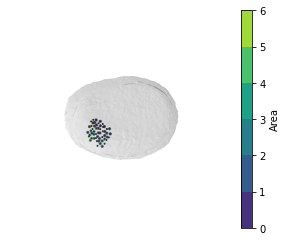

In [68]:
## SEB CODING HERE

color_palette_name = "viridis" 

# Gettting the center point in specific neuropile from database
xyz_neuropil = 'XYZ-ME'
xyz_df = R_post_df.copy()
xyz_pre = xyz_df[xyz_neuropil].tolist()
# Split each string by comma and convert the elements to floats
xyz_pre_arr = np.array([list(map(float, s.split(','))) for s in xyz_pre])
xyz_pre_arr_new = xyz_pre_arr * np.array([4,4,40])

### Data

_variable = 'Area' # 'Area' 'Area_zscore'
_data = spatial_span_df # Filtering out rows with no area

## Making the data discrete for the variable of interest

# Remove 0 values and calculate min and max
values = _data[_variable].fillna(0).tolist()
# Remove 0 values and calculate min and max
filtered_values = [value for value in values if value != 0.0]
min_value = min(filtered_values)
max_value = max(filtered_values)

# Create 6 linearly spaced discrete values between min and max
num_discrete_values = 6
discrete_values = np.linspace(min_value, max_value, num_discrete_values)

# Map each value to a discrete number (1 to 6)
discrete_mapped_values = [0 if 0 else np.digitize(value, discrete_values) for value in values]



dot_sizes = discrete_mapped_values
dot_sizes_ME = [size * 5 for size in dot_sizes]  # Increase size by a factor of X
    
size_color_map = {}
color_palette = sns.color_palette(color_palette_name, int(max(dot_sizes))) # before:  sns.color_palette(color_palette_name, len(set(dot_sizes)))


#Dot colors
dot_colors = []

for size in dot_sizes:
        if size != 0.0 and size not in size_color_map:
            size_color_map[size] = color_palette[len(size_color_map)]
        color = size_color_map.get(size, (1.0, 1.0, 1.0)) if size != 0.0 else (1.0, 1.0, 1.0)
        color = (*color[:3], 1.0)  # Make color fully opaque
        dot_colors.append(color)
        
### Plot
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
        
# Plot the object
ax.scatter(xyz_pre_arr_new[:, 0],xyz_pre_arr_new[:, 1],xyz_pre_arr_new[:, 2],s=5,c=dot_colors,alpha=0.9)
ax.scatter(xyz_pre_arr_new[:, 0], xyz_pre_arr_new[:, 1], xyz_pre_arr_new[:, 2], s=1,c='k',alpha=1) # All dots

OL_R = flywire.get_neuropil_volumes([neuropile_mesh]) 
navis.plot2d([OL_R], method='3d_complex', ax=ax)

ax.azim = mesh_azim
ax.elev = mesh_elev


# Create a custom color map using the first three colors from "tab10"
custom_cmap = plt.cm.colors.ListedColormap(sns.color_palette(color_palette_name)[:int(max(dot_sizes))])

# Create a ScalarMappable to specify colormap and data range
sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=plt.Normalize(vmin=min(dot_sizes), vmax=max(dot_sizes)))
sm.set_array([])  # An empty array is needed for the colormap to work properly

# Add color bar
cbar = plt.colorbar(sm, ax=ax, label=_variable)

In [42]:
## Making the data discrete for the variable of interest

# Remove 0 values and calculate min and max
values = _data[_variable].fillna(0).tolist()
filtered_values = [value for value in values if not 0] # not considering 0s
min_value = min(filtered_values)
max_value = max(filtered_values)

# Create 6 linearly spaced discrete values between min and max
num_discrete_values = 6
discrete_values = np.linspace(min_value, max_value, num_discrete_values)

# Map each value to the closest discrete value
discrete_mapped_values = [min(discrete_values, key=lambda x: abs(x - value)) if not 0 else 0 for value in values]

# Exploring methods and debugging with single cases

In [73]:
# Single case to debug

#i = 26
#curr_post = up_to_date_post_ids[i] 
outliers_threshold = 2  # Adjust this threshold as needed
curr_post = 720575940615464098 # Dm12: 720575940615464098 # L3:720575940637942837 #Tm16: 720575940608490761
#display(pre_post_counts[pre_post_counts['post'] == curr_post])


# Getting postsynapstic cells coordinates
curr_post_inputs = pd.DataFrame()
curr_post_inputs = curr_post_inputs.append(post_inputs[post_inputs['post_pt_root_id'] == curr_post].copy()) # here 'post' in the pre_inputs dataframe are our candidate presynapic cells
curr_post_inputs = curr_post_inputs.append(post_inputs[post_inputs['pre_pt_root_id']== curr_post].copy()) # here 'pre' in the pre_inputs dataframe are our candidate presynapic cells 
post_coords = curr_post_inputs['post_pt_position'].tolist()

# Getting presynaptic cells coordinates
curr_pre_ls = pre_post_counts[pre_post_counts['post_pt_root_id'] == curr_post]['pre_pt_root_id'].tolist() # single postsynaptic neuron candidate
curr_pre_inputs = pd.DataFrame()
curr_pre_inputs = curr_pre_inputs.append(pre_inputs[pre_inputs['post_pt_root_id'].isin(curr_pre_ls)].copy()) # here 'post' in the pre_inputs dataframe are our candidate presynapic cells
curr_pre_inputs = curr_pre_inputs.append(pre_inputs[pre_inputs['pre_pt_root_id'].isin(curr_pre_ls)].copy()) # here 'pre' in the pre_inputs dataframe are our candidate presynapic cells
pre_coords = curr_pre_inputs['pre_pt_position'].tolist()

# ## Filtering outliers
# # zscore from scipy (standardizing data and then calculating the score)
# z_scores = np.abs(stats.zscore(pre_coords))
        
# # Manual zscore based on mean
# mean = np.mean(pre_coords, axis=0)
# stddev = np.std(pre_coords, axis=0)
# z_scores_mean = np.abs((pre_coords - mean) / stddev)
        
# # Manual zscore based on median
# median = np.median(pre_coords, axis=0)
# mad = np.median(np.abs(pre_coords - median), axis=0) # Median abosolute deviation

# # Calculate the z-scores using the median and MAD
# z_scores_median = np.abs((pre_coords- median) / mad)

# # Applying outlier filter
# outlier_indices = np.where(z_scores_median > outliers_threshold)
# pre_coords = np.delete(pre_coords, outlier_indices, axis=0)

# # Initialize DBSCAN with appropriate parameters
# eps = 500  # Adjust the neighborhood radius as needed
# min_samples = round(len(pre_coords) / 5)  # Adjust the minimum number of points in a cluster as needed
# dbscan = DBSCAN(eps=eps, min_samples=min_samples)

# # Applying DBSCAN filter
# # Fit the DBSCAN model to your data
# dbscan.fit(pre_coords)

# # Find the indices of points that belong to clusters (excluding outliers)
# clustered_indices = np.where(dbscan.labels_ != -1)

# # Convert clustered_indices to a list of integers
# clustered_indices = clustered_indices[0]

# # Filter the points that belong to clusters
# filtered_points = [pre_coords[i] for i in clustered_indices]
# #pre_coords = filtered_points # rewritting the variable



pre_xyz = np.array([list(np.array(l)*[4,4,40]) for l in pre_coords])
pre_coords = pre_xyz # Temp (correct)
post_xyz = np.array([list(np.array(l)*[4,4,40]) for l in post_coords])
post_coords = post_xyz # Temp (correct)

# Calculate the center of the cloud of points
pre_center = np.mean(pre_coords, axis=0)

# Calculate the volume of the cloud using the convex hull method
from scipy.spatial import ConvexHull
hull = ConvexHull(pre_coords)
volume = hull.volume

#PCA to get an apporximate area of the volume
# Step 1: Center the data
pre_mean = np.mean(pre_coords, axis=0)
pre_centered_points = pre_coords - pre_mean
post_mean = np.mean(post_coords, axis=0)
post_centered_points = post_coords - pre_mean

# Step 2: Calculate the covariance matrix
pre_cov_matrix = np.cov(pre_centered_points, rowvar=False)
post_cov_matrix = np.cov(post_centered_points, rowvar=False)

# Step 3: Perform PCA to find the normal vector (eigenvector)
pre_eigenvalues, pre_eigenvectors = np.linalg.eigh(pre_cov_matrix)
pre_normal_vector = pre_eigenvectors[:, [1, 2]]  # PC2 and PC3

post_eigenvalues, post_eigenvectors = np.linalg.eigh(post_cov_matrix)
post_normal_vector = post_eigenvectors[:, [0, 1]]  # PC1 and PC2

# Step 4_ Doing the projection
pre_projected_points = pre_centered_points.dot(post_normal_vector)

#Calculate area
# Calculate the convex hull of the projected points
hull = ConvexHull(pre_projected_points)

# Calculate the area of the convex hull
area = hull.volume  # Area is calculated as volume in 2D
area_um2 = area / 10**6


# Getting the center postynaptic cells coordinate (single XYZ value)
try:
    old_curr_post = update_df[update_df['new_id'] == curr_post]['old_id'].tolist()[0]
except:
    
    old_curr_post = curr_post
single_post_coord = R_post_df[R_post_df['Updated_seg_id'] == old_curr_post]['XYZ-ME'].to_numpy(dtype=str, copy=True)
post_xyz = np.zeros([np.shape(single_post_coord)[0],3])
new_post_coords = np.zeros([np.shape(single_post_coord)[0],3])
for idx, coordinate in enumerate(single_post_coord):
    post_xyz[idx,:] = np.array([coordinate.split(',')],dtype=float)
    new_post_coords[idx,:] = np.array([coordinate.split(',')],dtype=float)
post_xyz *=[4,4,40] # For plotting it using navis

# Calculate the vector from the single point to the center of the cloud
vector_to_center = pre_center - post_xyz
#vector_to_center *= 10

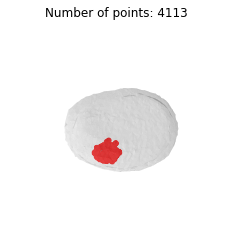

In [74]:
# Visulaizing plane ogf projection for postsynaptic coordinates 
# Trying PCA to get a 2D plane for the 3D cloud of points:

# Step 1: Center the data
post_mean = np.mean(post_coords, axis=0)
post_centered_points = post_coords - post_mean
pre_mean = np.mean(pre_coords, axis=0)
pre_centered_points = pre_coords - post_mean

# Step 2: Calculate the covariance matrix
post_cov_matrix = np.cov(post_centered_points, rowvar=False)

# Step 3: Perform PCA to find the normal vector (eigenvector)
post_eigenvalues, post_eigenvectors = np.linalg.eigh(post_cov_matrix)
post_normal_vector = post_eigenvectors[:, 2]  # Choosing dimention for later projection

# Step 4: Project points onto the plane
post_projected_points = post_centered_points - np.outer(post_centered_points.dot(post_normal_vector), post_normal_vector)

pre_projected_points = pre_centered_points - np.outer(pre_centered_points.dot(post_normal_vector), post_normal_vector)


# Create a 3D scatter plot
fig = plt.figure()
ax  = fig.add_subplot(projection='3d')

# Plot the original 3D points
ax.scatter(pre_coords[:, 0], pre_coords[:, 1], pre_coords[:, 2], marker='o', label='Original Points', c='red')

#ax.scatter(post_coords[:, 0], post_coords[:, 1], post_coords[:, 2], marker='o', label='Original Points', c='blue')

# # Plot the plane
# d = -mean.dot(post_normal_vector)  # Calculate the constant in the plane equation
# xx, yy = np.meshgrid(np.linspace(np.min(pre_coords[:, 0]), np.max(pre_coords[:, 0]), 10),
#                      np.linspace(np.min(pre_coords[:, 1]), np.max(pre_coords[:, 1]), 10))
# zz = (-post_normal_vector[0] * xx - post_normal_vector[1] * yy - d) / post_normal_vector[2]
# ax.plot_surface(xx, yy, zz, alpha=0.5, color='green', label='Fitted Plane')

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f'Number of points: {len(pre_coords)}')

OL_R = flywire.get_neuropil_volumes([neuropile_mesh]) 
navis.plot2d([OL_R], method='3d_complex', ax=ax)

ax.azim = mesh_azim
ax.elev = mesh_elev


# Show the 3D plot
plt.show()    

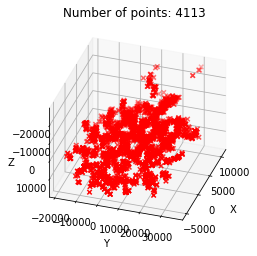

In [75]:
# Create a 3D scatter plot
fig = plt.figure()
ax  = fig.add_subplot(projection='3d')


# Plot the projected points onto the plane
ax.scatter(pre_projected_points[:, 0], pre_projected_points[:, 1], pre_projected_points[:, 2], marker='x', label='Projected Points', c='red')


# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f'Number of points: {len(pre_coords)}')

# OL_R = flywire.get_neuropil_volumes([neuropile_mesh]) 
# navis.plot2d([OL_R], method='3d_complex', ax=ax)

ax.azim = mesh_azim
ax.elev = mesh_elev


# Show the 3D plot
plt.show()     

In [76]:
import plotly.graph_objects as go

_data = _data [~np.isnan(_data['Area'])].copy()

# Create an empty figure
fig = go.Figure()

# Define the marker size (adjust this value as needed)
marker_size = 2  # Change this value to your desired marker size

    
#print(post_id)
trace = go.Scatter3d(
    x=pre_coords[:, 0],
    y=pre_coords[:, 1],
    z=pre_coords[:, 2],
    mode='lines+markers',  # Combine lines and markers
    marker=dict(size=marker_size),
    line=dict(width=2))
fig.add_trace(trace)

# Show the figure
fig.show()

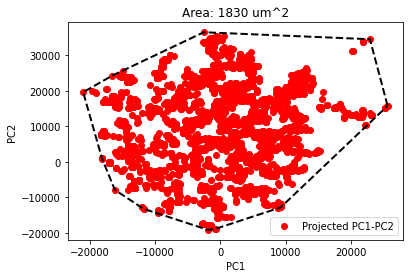

In [77]:
# Create a 2D scatter plot for PCA-based projection

post_normal_vector = post_eigenvectors[:, [0, 1]]  # PC1 and PC2
pre_projected_points = pre_centered_points.dot(post_normal_vector)

#Calculate area
# Calculate the convex hull of the projected points
hull = ConvexHull(pre_projected_points)

# Calculate the area of the convex hull
area = hull.volume  # Area is calculated as volume in 2D
area_um2 = area / 10**6

# Create a scatter plot of the PC1 and PC2 components
plt.scatter(pre_projected_points[:, 0], pre_projected_points[:, 1], marker='o', label='Projected PC1-PC2', c='red')

plt.plot(pre_projected_points[hull.vertices,0], pre_projected_points[hull.vertices,1], 'k--', lw=2)
#plt.plot(projected_points[hull.vertices[0],0], projected_points[hull.vertices[0],1], 'ko')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(f'Area: {round(area_um2)} um^2')

# Show the plot
plt.legend()
plt.show()

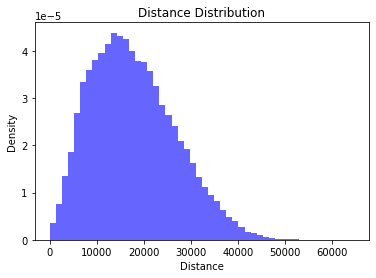

In [78]:
# For eps parameter adjustments

# Calculate pairwise distances
distances = []
for i in range(len(pre_coords)):
    for j in range(i+1, len(pre_coords)):
        distance = np.linalg.norm(pre_coords[i] - pre_coords[j])
        distances.append(distance)

# Create a histogram or KDE plot of distances
plt.hist(distances, bins=50, density=True, alpha=0.6, color='b')
plt.xlabel('Distance')
plt.ylabel('Density')
plt.title('Distance Distribution')
plt.show()

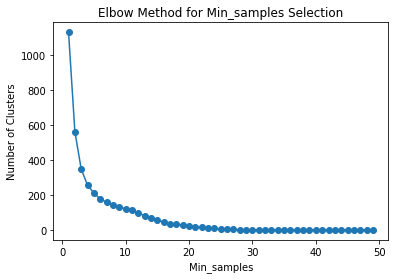

In [213]:
desired_num_clusters = 2  # Replace with your desired number of clusters

# For min_samples parameter adjustments
# Create an array of min_samples values to test
min_samples_values = range(1, 50)
num_clusters = []

for min_samples in min_samples_values:
    dbscan = DBSCAN(eps=500, min_samples=min_samples)
    dbscan.fit(pre_coords)
    num_clusters.append(len(set(dbscan.labels_)) - 1)  # Subtract 1 to account for noise points

# Find the min_samples value that gives the desired number of clusters
selected_min_samples = None
for min_samples, num_cluster in zip(min_samples_values, num_clusters):
    if num_cluster == desired_num_clusters:
        selected_min_samples = min_samples
        break

# Plot the number of clusters vs. min_samples
plt.plot(min_samples_values, num_clusters, marker='o')
plt.xlabel('Min_samples')
plt.ylabel('Number of Clusters')
plt.title('Elbow Method for Min_samples Selection')

# Label the plot with the selected min_samples value
if selected_min_samples is not None:
    plt.text(15, 40, f'Min_samples = {selected_min_samples} for {desired_num_clusters} clusters', fontsize=12, verticalalignment='bottom')

plt.show()

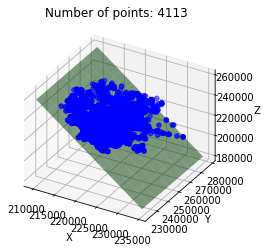

In [214]:
# Trying PCA to get a 2D plane for the 3D cloud of points:

# Step 1: Center the data
mean = np.mean(pre_coords, axis=0)
centered_points = pre_coords - mean

# Step 2: Calculate the covariance matrix
cov_matrix = np.cov(centered_points, rowvar=False)

# Step 3: Perform PCA to find the normal vector (eigenvector)
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
normal_vector = eigenvectors[:, 0]  # Smallest eigenvalue corresponds to the normal vector

# Step 4: Project points onto the plane
projected_points = centered_points - np.outer(centered_points.dot(normal_vector), normal_vector)




# Create a 3D scatter plot
fig = plt.figure()
ax  = fig.add_subplot(projection='3d')

# Plot the original 3D points
ax.scatter(pre_coords[:, 0], pre_coords[:, 1], pre_coords[:, 2], marker='o', label='Original Points', c='blue')

# Plot the plane
d = -mean.dot(normal_vector)  # Calculate the constant in the plane equation
xx, yy = np.meshgrid(np.linspace(np.min(pre_coords[:, 0]), np.max(pre_coords[:, 0]), 10),
                     np.linspace(np.min(pre_coords[:, 1]), np.max(pre_coords[:, 1]), 10))
zz = (-normal_vector[0] * xx - normal_vector[1] * yy - d) / normal_vector[2]
ax.plot_surface(xx, yy, zz, alpha=0.5, color='green', label='Fitted Plane')

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f'Number of points: {len(pre_coords)}')


# Show the 3D plot
plt.show()         

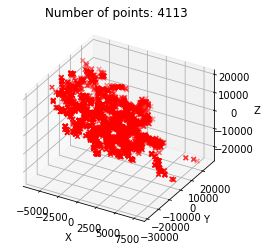

In [215]:
# Create a 3D scatter plot
fig = plt.figure()
ax  = fig.add_subplot(projection='3d')


# Plot the projected points onto the plane
ax.scatter(projected_points[:, 0], projected_points[:, 1], projected_points[:, 2], marker='x', label='Projected Points', c='red')


# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f'Number of points: {len(pre_coords)}')


# Show the 3D plot
plt.show()         

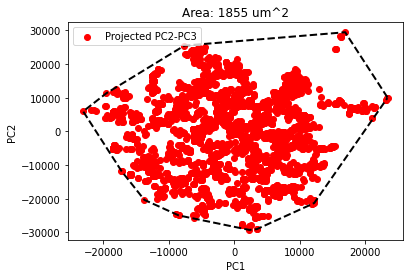

In [216]:
# Create a 2D scatter plot for PCA-based projection

normal_vector = eigenvectors[:, [1, 2]]  # PC2 and PC3
projected_points = centered_points.dot(normal_vector)

#Calculate area
# Calculate the convex hull of the projected points
hull = ConvexHull(projected_points)

# Calculate the area of the convex hull
area = hull.volume  # Area is calculated as volume in 2D
area_um2 = area / 10**6

# Create a scatter plot of the PC1 and PC2 components
plt.scatter(projected_points[:, 0], projected_points[:, 1], marker='o', label='Projected PC2-PC3', c='red')

plt.plot(projected_points[hull.vertices,0], projected_points[hull.vertices,1], 'k--', lw=2)
#plt.plot(projected_points[hull.vertices[0],0], projected_points[hull.vertices[0],1], 'ko')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(f'Area: {round(area_um2)} um^2')

# Show the plot
plt.legend()
plt.show()

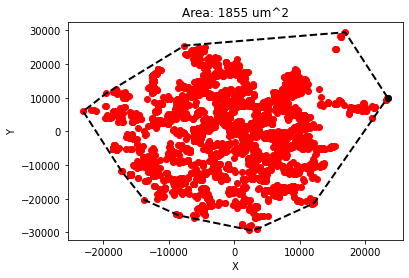

In [217]:
# Create a 2D scatter plot for brute force projection
fig = plt.figure()

# Extract the 2D coordinates
projected_2d = projected_points[:, [0, 1]]  # Assuming you want the first two dimensions

#Calculate area
# Calculate the convex hull of the projected points
hull = ConvexHull(projected_points)

# Calculate the area of the convex hull
area = hull.volume  # Area is calculated as volume in 2D
area_um2 = area / 10**6

# Create a scatter plot of the 2D coordinates
plt.scatter(projected_2d[:, 0], projected_2d[:, 1], marker='o', label='Projected 2D Points', c='red')

plt.plot(projected_2d[hull.vertices,0], projected_2d[hull.vertices,1], 'k--', lw=2)
plt.plot(projected_2d[hull.vertices[0],0], projected_2d[hull.vertices[0],1], 'ko')



plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Area: {round(area_um2)} um^2')

plt.show()    

In [218]:
len(curr_pre_coords)

1726

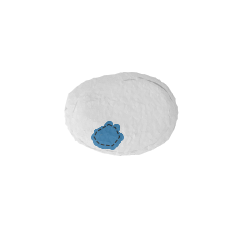

In [220]:
# Brief visualization for volumes
fig = plt.figure()
ax  = fig.add_subplot(projection='3d')
ax.plot(pre_coords[:,0], pre_coords[:,1], pre_coords[:,2],'o')
ax.plot(pre_coords[hull.vertices,0], pre_coords[hull.vertices,1], pre_coords[hull.vertices,2], 'k--', lw=1)
#ax.plot(pre_coords[hull.vertices[0],0], pre_coords[hull.vertices[0],1],pre_coords[hull.vertices[0],2], 'ro')

OL_R = flywire.get_neuropil_volumes([neuropile_mesh]) 
navis.plot2d([OL_R], method='3d_complex', ax=ax)

ax.azim = mesh_azim
ax.elev = mesh_elev

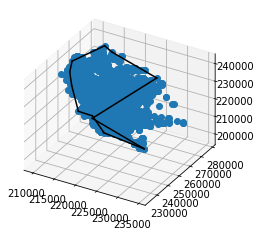

In [221]:
# Brief visualization for volumes
fig = plt.figure()
ax  = fig.add_subplot(projection='3d')
ax.plot(pre_coords[:,0], pre_coords[:,1], pre_coords[:,2],'o')
for simplex in hull.simplices:
    ax.plot(pre_coords[simplex, 0], pre_coords[simplex, 1], pre_coords[simplex, 2], 'k-')

Text(0.5, 0.92, '3D Plot with Volume Information')

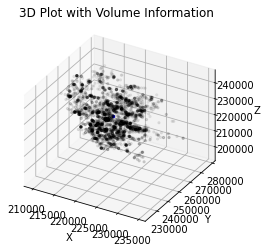

In [222]:
# Brief visualization of points
fig = plt.figure()
ax  = fig.add_subplot(projection='3d')
#ax.scatter(new_post_coords[:,0],new_post_coords[:,1],new_post_coords[:,2],'.',color=[1,0,0], s = 5) # Location of postsynaptic cell
ax.scatter(pre_center[0],pre_center[1],pre_center[2],'.',color=[0,0,1], s = 5) # Location of center of cloud of presynaptic cells
ax.scatter(pre_coords[:,0],pre_coords[:,1],pre_coords[:,2],'.',color=[0,0,0,0.1], s = 5) # Cloud


# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Plot with Volume Information')

# # Plot the vector as an arrow
# ax.quiver(post_xyz[0, 0], post_xyz[0, 1], post_xyz[0, 2],
#           vector_to_center[:,0], vector_to_center[:,1], vector_to_center[:,2],
#           color='g', label='Vector to Center')



# OL_R = flywire.get_neuropil_volumes([neuropile_mesh]) 
# navis.plot2d([OL_R], method='3d_complex', ax=ax) # scalebar = '20 um'

# ax.azim = mesh_azim
# ax.elev = mesh_elev

# Code on porgress or old tests


#### Attemps to project the 3D cloud into a 2D plane.

In [ ]:
## Projecting to a 2D plane

# Normalize the vector_to_center to define the normal vector of the plane
normal_vector = vector_to_center / np.linalg.norm(vector_to_center)

# Calculate the projection of all cloud points onto the plane
projections = np.dot(pre_xyz - post_xyz, np.squeeze(normal_vector))

# Calculate the projected points
projected_pre_xyz = pre_xyz - projections[:, np.newaxis] * normal_vector

# Calculate the projection of the center onto the plane
projected_pre_center = pre_center - np.dot(pre_center - post_xyz, np.squeeze(normal_vector)) * normal_vector

# Calculate the projection of the postsynaptic cell
projected_post_xyz = post_xyz - np.dot(post_xyz - post_xyz, np.squeeze(normal_vector)) * normal_vector

In [ ]:
# Create a 2D scatter plot of the projected points
plt.scatter(projected_pre_xyz[:, 0], projected_pre_xyz[:, 1], label='Presynaptic cell dendrites')
plt.scatter(projected_post_xyz[:, 0], projected_post_xyz[:,1], c='r', marker='x', label='Postsynaptic cell')
plt.scatter(projected_pre_center[:,0], projected_pre_center[:,1], c='g', marker='o', label='Presynaptic cell center')

# Plot the vector_to_center as an arrow
plt.quiver(projected_post_xyz[:,0], projected_post_xyz[:,1],
           vector_to_center[:,0], vector_to_center[:,1],
           angles='xy', scale_units='xy', scale=1, color='b', label='Vector to Center')

# Set axis labels
plt.xlabel('X Projection')
plt.ylabel('Y Projection')

# Set legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
## Testing another plane:

# Calculate the new 2D plane's normal vector
new_normal_vector = np.array([1.0, 0.0, 0.0])  # Example: A plane perpendicular to the X-axis

# Calculate the projection of the points onto the new 2D plane
projection_magnitude = np.dot(pre_xyz - post_xyz, new_normal_vector)

# Create a 2D scatter plot of the projected points onto the new 2D plane
plt.scatter(projection_magnitude, projected_pre_xyz[:, 1], label='Presynaptic cell dendrites')
plt.scatter(projection_magnitude, projected_post_xyz[:, 1], c='r', marker='x', label='Postsynaptic cell')
plt.scatter(projection_magnitude, projected_pre_center[:, 1], c='g', marker='o', label='Presynaptic cell center')

# Plot the projection of the vector_to_center as a single dot in the new 2D plane
plt.scatter(0, 0, c='b', marker='o', label='Projected Vector to Center')

# Set axis labels
plt.xlabel('X Projection (New Plane)')
plt.ylabel('Y Projection')

# Set legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
volume



In [ ]:
vector_to_center[:,0]

In [ ]:
navis.plot3d([pre_xyz], color= [1,0,0]) # [0.5,0.5,0.5,0.1],[1,1,0],[1,0,1]]
navis.plot3d([OL_R], color= [0.5,0.5,0.5,0.1]) # [0.5,0.5,0.5,0.1],[1,1,0],[1,0,1]]